# Uber Data Challenge - Part 2

Author: Ryan McCaffrey

Due Date: Friday, 7/28/17

## Exploratory Data Analysis and Feature Engineering

We'll start by importing the necessary Python packages and reading in the data.

In [1]:
# Import Python packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read in dataset
df = pd.read_csv('ds_challenge_v2_1_data.csv')

Let's inspect the size of the dataset and see what it looks like.

In [3]:
df.shape

(54681, 11)

In [4]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
id                      54681 non-null int64
city_name               54681 non-null object
signup_os               47824 non-null object
signup_channel          54681 non-null object
signup_date             54681 non-null object
bgc_date                32896 non-null object
vehicle_added_date      13134 non-null object
vehicle_make            13223 non-null object
vehicle_model           13223 non-null object
vehicle_year            13223 non-null float64
first_completed_date    6137 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 4.6+ MB


We notice some of the fields have NaNs.  Let's get a feel for how many NaNs we have for each column.

In [6]:
for i in df.columns:
    print(i+':', df[i].isnull().sum()/len(df[i]))

id: 0.0
city_name: 0.0
signup_os: 0.125400047549
signup_channel: 0.0
signup_date: 0.0
bgc_date: 0.398401638595
vehicle_added_date: 0.759806879903
vehicle_make: 0.758179257878
vehicle_model: 0.758179257878
vehicle_year: 0.758179257878
first_completed_date: 0.887767231762


There's a significant number of missing values for several columns. A major indicator of whether or not someone is truly going to become a driver could possibly be the number of missing values per row.  Essentially the thinking here is if you don't perform a background check and don't register the make, model and year of your car with Uber then you are probably not serious about becoming a driver.  So let's create flags for each of the relevant columns to signify whether or not there's a missing value in each row.  We will use only one flag to represent 'vehicle_make', 'vehicle_model' and 'vehicle_year' since they all have the same number of NaNs.

We should suspect that rows with no missing values will have a higher tendency to become drivers than rows with several missing values.  Note, this is an example of data that is MNAR - Missing Not At Random.

In [7]:
df['signup_os_flag'] = df['signup_os'].notnull().astype(int)
df['bgc_date_flag'] = df['bgc_date'].notnull().astype(int)
df['vehicle_added_date_flag'] = df['vehicle_added_date'].notnull().astype(int)
df['vehicle_make_flag'] = df['vehicle_make'].notnull().astype(int)

We also notice there are several columns referencing dates.  Let's start by converting these columns to pandas datetime objects.

In [8]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['bgc_date'] = pd.to_datetime(df['bgc_date'])
df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date'])
df['first_completed_date'] = pd.to_datetime(df['first_completed_date'])

In [9]:
#df['missing_sum'] = df.iloc[:,:-1].isnull().sum(axis=1)

Perhaps the amount of time elapsed between signing up with Uber and consenting to their background check would be a good indicator of whether or not they actually complete their first drive.  For example, I would think applicants who are eager to become drivers would likely consent to a background check very quickly following their signing up.  Let's compute the time difference between 'bgc_date' and 'signup_date' and assign that to a new feature.

In [10]:
# Compute time differences, replace negative time differences with 0 and replace NaN values with -1
df['signup_bgc_delta'] = (df['bgc_date'] - df['signup_date']) / np.timedelta64(1, 'D')
df['signup_bgc_delta'] = df['signup_bgc_delta'].clip(lower=0).fillna(-1)

And let's do the same thing for the time elapsed between 'vehicle_added_date' and 'signup_date'.

In [11]:
# Compute time differences, replace negative time differences with 0 and replace NaN values with -1
df['signup_vehicle_delta'] = (df['vehicle_added_date'] - df['signup_date']) / np.timedelta64(1, 'D')
df['signup_vehicle_delta'] = df['signup_vehicle_delta'].clip(lower=0).fillna(-1)

Any time difference values that were less than 0 days (meaning the vehicle registration or background check was completed before they even signed up) was converted to 0 days.  Additionally, we convert the NaN values to -1 since 0 days is reserved to signify eager applicants who signed up and did their background check and/or vehicle registration in the same day.

In addition to the NaNs, let's also inspect the columns to see if there are any zero elements in the columns. 

In [12]:
for i in df.columns[:10]:
    try:
        print(i, df[df[i] == 0][i].count())
    except:
        print(i, 0)

id 0
city_name 0
signup_os 0
signup_channel 0
signup_date 0
bgc_date 0
vehicle_added_date 0
vehicle_make 0
vehicle_model 0
vehicle_year 4


It looks like 'vehicle_year' has 4 rows that are zero.  Let's replace them with NaN.

In [13]:
df['vehicle_year'].replace(0,np.NaN, inplace=True)

Now let's check out the value counts of 'vehicle_year'.

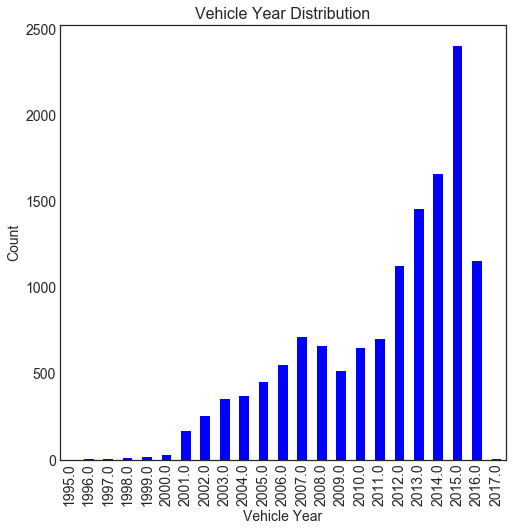

In [14]:
plt.style.use('seaborn-white')
df['vehicle_year'].value_counts().sort_index().plot(kind = "bar", color='b', figsize=(8,8),fontsize=14)
plt.xlabel('Vehicle Year',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title("Vehicle Year Distribution", fontsize=16);

In [15]:
# Replace NaN values with 0
df['vehicle_year'] = df['vehicle_year'].fillna(0)

It looks like most vehicle registered with Uber are newer vehicles.  According to the [US Bureau of Transportation Statistics](https://www.rita.dot.gov/bts/sites/rita.dot.gov.bts/files/publications/national_transportation_statistics/html/table_01_26.html_mfd) the average age of passenger cars on the road in 2016 is 11.6 years old.  Let's see what percentage of Uber-registered vehicles are less than 11.6 years old.

In [16]:
df[df['vehicle_year']>(2016-11.6)]['vehicle_year'].count()/(len(df['vehicle_year'])-df['vehicle_year'].isnull().sum())

0.2197472613887822

This tells us that over 90% of the Uber-registered passenger vehicles are newer than the national average of 11.6 years old.  Let's create a flag called 'old_car', which we will assign to a new feature.  (Maybe Uber drivers are using Uber to help pay for their new cars...haha!)

In [17]:
df['old_car'] = df['vehicle_year'].apply(lambda x: 1 if x < (2016-11.6) else 0)

Keep in mind we shouldn't expect this flag to have great feature importance since the flag only affects roughly 2.2% of the overall driver population, nevertheless, it could provide slight improvements in model performance.  The thinking here for this new feature could be that drivers with newer cars may be more inclined to embrace technology and therefore be more likely to engage with Uber as a driver.

In [18]:
df['old_car'].sum()/len(df['vehicle_year'])

0.7802527386112178

Let's go back to the date columns and break apart the timestamps into more meaningful representations (e.g., month, day of month, day of week, etc.).

In [19]:
print('signup year:', pd.to_datetime(df['signup_date']).dt.year.unique())
print('signup month:', pd.to_datetime(df['signup_date']).dt.month.unique())
print('signup day:',pd.to_datetime(df['signup_date']).dt.day.unique())
print('signup day of week:',pd.to_datetime(df['signup_date']).dt.dayofweek.unique(),'\n')

print('bgc year:', pd.to_datetime(df['bgc_date']).dt.year.unique())
print('bgc month:', pd.to_datetime(df['bgc_date']).dt.month.unique())
print('bgc day:', pd.to_datetime(df['bgc_date']).dt.day.unique(),'\n')

print('vehicle added year:', pd.to_datetime(df['vehicle_added_date']).dt.year.unique())
print('vehicle added month:', pd.to_datetime(df['vehicle_added_date']).dt.month.unique())
print('vehicle added day:', pd.to_datetime(df['vehicle_added_date']).dt.day.unique())

signup year: [2016]
signup month: [1]
signup day: [ 2 21 11 29 10 18 14 26  5 25  4 12 13 15 24 16  7  6  8 28 20  9 17  1 22
 27 23 19 30  3]
signup day of week: [5 3 0 4 6 1 2] 

bgc year: [   nan  2016.]
bgc month: [ nan   1.   2.   3.]
bgc day: [ nan  11.   3.  25.  18.  16.   5.   9.  12.  20.   7.  17.  15.  26.  27.
   8.  21.   2.  31.  22.  10.  24.  30.  23.   4.  29.  19.   6.  14.  28.
   1.  13.] 

vehicle added year: [   nan  2016.]
vehicle added month: [ nan   2.   1.   3.]
vehicle added day: [ nan   3.  26.  22.  21.  24.  12.  17.   6.  28.  19.  25.   1.  15.  11.
  30.  18.  14.  10.  23.  16.  20.   8.   4.  29.   2.   9.  27.   7.   5.
  13.  31.]


The first thing we notice is there's no variation in 'signup_year' and 'signup_month' so we will not use them as features since they provide no insight.  We will also not use 'bgc_year' and 'vehicle_added_year' as they only have two values: 2016 and NaN.  The NaN values should already be captured by both the missing value flags and month and day columns.  The rationale for breaking the dates down into both day of week and day of month is these features may capture time sensitive information specific to different periods.  For instance, the day of month feature would capture Uber promotional campaigns that target driver signups toward the beginning or end of each month, and the day of week feature would capture Uber promotional campaigns that target drivers on weekends or working weekdays. 

Let's now create these timestamp-derived features and replace any NaNs with -1.

In [20]:
# Extract month, day of month, day of week from date columns
df['signup_day'] = pd.to_datetime(df['signup_date']).dt.day.fillna(-1)
df['signup_day_of_week'] = pd.to_datetime(df['signup_date']).dt.dayofweek.fillna(-1)

df['bgc_month'] = pd.to_datetime(df['bgc_date']).dt.month.fillna(-1)
df['bgc_day'] = pd.to_datetime(df['bgc_date']).dt.day.fillna(-1)
df['bgc_day_of_week'] = pd.to_datetime(df['bgc_date']).dt.dayofweek.fillna(-1)

df['vehicle_added_month'] = pd.to_datetime(df['vehicle_added_date']).dt.month.fillna(-1)
df['vehicle_added_day'] = pd.to_datetime(df['vehicle_added_date']).dt.day.fillna(-1)
df['vehicle_added_day_of_week'] = pd.to_datetime(df['vehicle_added_date']).dt.dayofweek.fillna(-1)

Let's inspect the signup categorical variables.

In [21]:
df['city_name'].value_counts(normalize=True, dropna=False)

Strark     0.540535
Berton     0.367897
Wrouver    0.091567
Name: city_name, dtype: float64

In [22]:
df['signup_os'].value_counts(normalize=True, dropna=False)

ios web        0.304164
android web    0.273294
NaN            0.125400
windows        0.123919
mac            0.106509
other          0.066714
Name: signup_os, dtype: float64

In [23]:
df['signup_channel'].value_counts(normalize=True, dropna=False)

Paid        0.437775
Referral    0.316673
Organic     0.245551
Name: signup_channel, dtype: float64

Because the signup categorical variables do not have high-dimensionality and there seemingly does not exist any linear or relative relationship among the variables (e.g., like a movie rating system or restaurant rankings, etc.) we propose to dummify the categorical signup features.  We will drop the first variable as it is redundant and we do not want to overdefine the feature.

In [24]:
dum_city_name = pd.get_dummies(df['city_name'], drop_first=True)
dum_signup_os = pd.get_dummies(df['signup_os'], drop_first=True)
dum_signup_channel = pd.get_dummies(df['signup_channel'], drop_first=True)

Now we'll take a deeper look at the categorical features related to the vehicle make and model.

In [25]:
df['vehicle_make'].nunique()

46

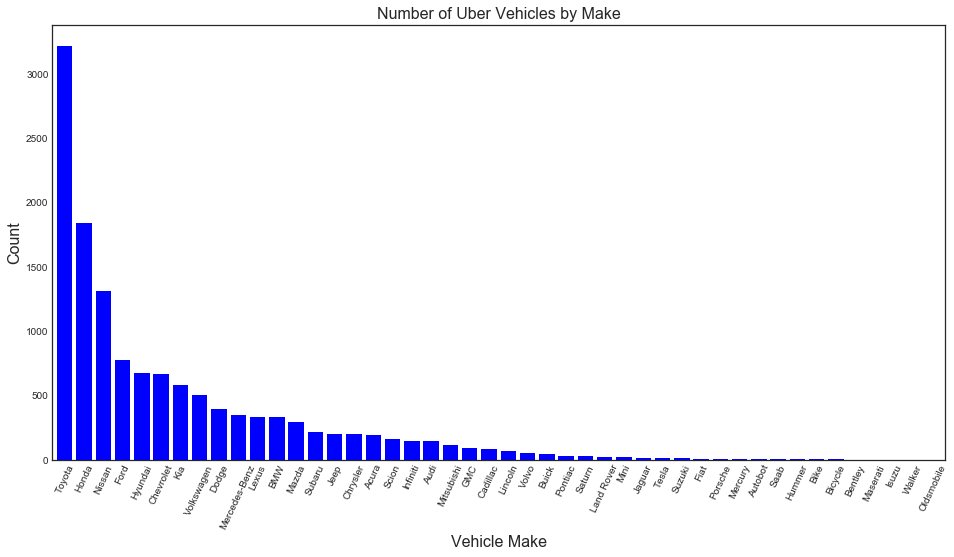

In [26]:
ax = df['vehicle_make'].value_counts(dropna=True).plot(kind = 'bar', rot=65, figsize=(16,8), width=.8, color='b', legend=False)
ax.set_xlabel('Vehicle Make', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Number of Uber Vehicles by Make', fontsize=16);

Because there are so many different vehicle manufacturers, instead of dummifying them we will convert them to numeric values using the LabelEncoder() method.

In [27]:
# Convert NaN values to 'None' so that LabelEncoder() can handle them without throwing an error
df['vehicle_make'].replace(np.NaN,'None', inplace=True)

In [28]:
le = LabelEncoder()
df['vehicle_make'] = le.fit_transform(df['vehicle_make'])

When we inspect the vehicle models we find that there are several hundred different models.

In [29]:
df['vehicle_model'].nunique()

368

In [30]:
df['vehicle_model'].unique()[:50]

array([nan, 'Corolla', 'Sonata', 'DTS', 'Prius V', 'Optima', 'Durango',
       'C-Class', 'G Sedan', 'Civic', '500X', 'Escalade', 'RDX', 'ES',
       'Prius', 'CR-V', 'CT', 'Terrain', 'G6', 'Civic Hybrid', 'Accord',
       'Versa', 'Odyssey', 'Grand Cherokee', 'GTI', 'F-150', 'A4',
       'Insight Hybrid', 'Elantra', 'Camry', 'Sentra', 'Malibu', 'Soul',
       'Altima', 'Journey', 'Compass', '3-series', 'Cruze', 'Forester',
       'Century', 'MAZDA3', 'XV Crosstrek', 'Charger', 'Flex', '7-series',
       'RAV4', 'Traverse', 'Avenger', 'Jetta', 'Expedition'], dtype=object)

We can see from the above model names, some of these model names exclusively contain alphabetic characters and some contain a mixture of alphabetic and numeric characters (i.e., alphanumeric).  Some findings suggest that car names with alphanumeric characters (e.g., ES350) signify luxury and fanciness, whereas car names with just alphabetic characters (e.g., Yaris) signify value, cheaper and mass-market cars.  [See this article for details](http://www.atlasobscura.com/articles/how-cars-get-named).  Let's create a flag for the cars that contain numbers in them.  The rationale here would be that we expect for some reason owners of higher-end cars to be more or less likely to follow through and complete their first drive than owners of more common, mass-market cars.

In [31]:
# Function to flag whether or not a car model has a number in it
# Yes = 1, No = 0, NaN = -1
def has_num(s):
    try:
        return int(any(i.isdigit() for i in s))
    except:
        return -1

In [32]:
# Apply above function to 'vehicle_model' feature
df['lux_vehicle'] = df['vehicle_model'].apply(has_num)

In [33]:
df['lux_vehicle'].value_counts(normalize=True)

-1    0.758179
 0    0.216474
 1    0.025347
Name: lux_vehicle, dtype: float64

We need to use LabelEncoder() on 'vehicle_model' just like we did for 'vehicle_make'. 

In [34]:
# Convert NaN values to 'None' so that LabelEncoder() can handle them without throwing an error
df['vehicle_model'].replace(np.NaN, 'None', inplace=True)

In [35]:
le = LabelEncoder()
df['vehicle_model'] = le.fit_transform(df['vehicle_model'])

Finally, we have to binarize the 'first_completed_date' column as that is our target variable.  This will convert the problem into a binary classification problem.

In [36]:
df['first_drive'] = df['first_completed_date'].isnull().astype(int)

### Question 1 - *What fraction of the driver signups took a first trip? (2 Points)*

In [37]:
df['first_drive'].value_counts(normalize=True)

1    0.887767
0    0.112233
Name: first_drive, dtype: float64

**PLEASE NOTE: Here we are defining 1 to be the applicant who signs up and does NOT complete his/her first trip as a driver, and defining 0 to be the applicant who signs up and does complete his/her first trip as a driver.  I am defining things this way because of my understanding of the business problem and how I believe it will simplify my model evaluation in the prediction phase.**

Only 11.2% of driver applicants who signed up with Uber actually took a first trip as a driver.  Also, when we start the modeling we'll need to keep in mind that this is our target variable and we are dealing with an imbalanced dataset with respect to the target variable.

### Question 2 - *Build a predictive model to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.  (2 Points)*

Let's first start by putting together our design matrix, X.

In [38]:
use_cols =['vehicle_make', 'vehicle_model','vehicle_year','bgc_date_flag','vehicle_added_date_flag', \
           'signup_os_flag', 'vehicle_make_flag','signup_bgc_delta', 'signup_vehicle_delta','old_car',\
           'signup_day', 'signup_day_of_week', 'bgc_month', 'bgc_day','bgc_day_of_week', \
           'vehicle_added_month', 'vehicle_added_day','vehicle_added_day_of_week', 'lux_vehicle']

In [39]:
X = pd.concat([dum_city_name,dum_signup_os,dum_signup_channel,df[use_cols]],axis=1)
y = df['first_drive']

We also need to properly scale our design matrix to have unit variance, which we will do using StandardScaler.

In [40]:
# Scale and normalize design matrix
stand = StandardScaler()
Xt = stand.fit_transform(X)

Before starting the modeling phase, we must first decide on what metric to use to evaluate our models.  Deciding what evaluation metric to use is often informed by analyzing the business side of the problem.  Given that this is a binary classification problem, some of the possible metrics we may want to consider include accuracy, precision, recall, f1 score and ROC AUC.

Here we will perform 5-fold cross-validation on 8 different types of binary classification models to evaluate which one is the best.

In [41]:
cv = StratifiedKFold(n_splits=5,random_state=99, shuffle=True)
scoring = 'recall'

In [42]:
lr = LogisticRegression(class_weight='balanced',random_state=99)
s = cross_val_score(lr, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("Logistic Regression", s.mean().round(3), s.std().round(3)))

dt = DecisionTreeClassifier(class_weight='balanced',random_state=99)
s = cross_val_score(dt, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

rf = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=99)
s = cross_val_score(rf, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

et = ExtraTreesClassifier(n_estimators=100,class_weight='balanced',random_state=99)
s = cross_val_score(et, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", s.mean().round(3), s.std().round(3)))

ad = AdaBoostClassifier(n_estimators=100,random_state=99)
s = cross_val_score(ad, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("AdaBoost", s.mean().round(3), s.std().round(3)))

gb = GradientBoostingClassifier(n_estimators=100,random_state=99)
s = cross_val_score(gb, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("Gradient Boosting", s.mean().round(3), s.std().round(3)))

kn = KNeighborsClassifier()
s = cross_val_score(kn, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("K Nearest Neighbors", s.mean().round(3), s.std().round(3)))

sv = SVC(random_state=99)
s = cross_val_score(sv, Xt, y, cv=cv, scoring=scoring)
print("{} Score:\t{:0.3} ± {:0.3}".format("Support Vector", s.mean().round(3), s.std().round(3)))

Logistic Regression Score:	0.924 ± 0.002
Decision Tree Score:	0.955 ± 0.001
Random Forest Score:	0.963 ± 0.002
Extra Trees Score:	0.961 ± 0.002
AdaBoost Score:	0.962 ± 0.001
Gradient Boosting Score:	0.963 ± 0.002
K Nearest Neighbors Score:	0.957 ± 0.003
Support Vector Score:	0.961 ± 0.002


We considered the following classification models: Logistic Regression, Decision Tree, Random Forest, Extra Trees, AdaBoost, Gradient Boosting, K Nearest Neighbors and Support Vector Machines.  

Here is a summary of the accuracy, area under the curve (AUC), f1 score, precision and recall for all 8 model types based on a 5-fold cross-validation evaluation.  The model with the best score for each metric is highlight in bold.

Accuracy
- Logistic Regression Score:	0.926 ± 0.001
- Decision Tree Score:	0.917 ± 0.001
- Random Forest Score:	0.938 ± 0.001
- Extra Trees Score:	0.936 ± 0.002
- AdaBoost Score:	0.942 ± 0.001
- **Gradient Boosting Score:	0.944 ± 0.001**
- K Nearest Neighbors Score:	0.933 ± 0.003
- Support Vector Score:	0.942 ± 0.002

AUC
- Logistic Regression Score:	0.97 ± 0.002
- Decision Tree Score:	0.786 ± 0.006
- Random Forest Score:	0.961 ± 0.002
- Extra Trees Score:	0.955 ± 0.001
- AdaBoost Score:	0.97 ± 0.002
- **Gradient Boosting Score:	0.972 ± 0.002**
- K Nearest Neighbors Score:	0.941 ± 0.004
- Support Vector Score:	0.951 ± 0.004

F1 Score
- Logistic Regression Score:	0.957 ± 0.001
- Decision Tree Score:	0.953 ± 0.001
- Random Forest Score:	0.965 ± 0.001
- Extra Trees Score:	0.964 ± 0.001
- AdaBoost Score:	0.967 ± 0.001
- **Gradient Boosting Score:	0.968 ± 0.001**
- K Nearest Neighbors Score:	0.962 ± 0.002
- Support Vector Score:	0.967 ± 0.001

Precision
- Logistic Regression Score:	0.992 ± 0.001
- Decision Tree Score:	0.951 ± 0.001
- Random Forest Score:	0.967 ± 0.002
- Extra Trees Score:	0.967 ± 0.001
- AdaBoost Score:	0.973 ± 0.001
- **Gradient Boosting Score:	0.974 ± 0.002**
- K Nearest Neighbors Score:	0.968 ± 0.002
- **Support Vector Score:	0.974 ± 0.002**

Recall
- Logistic Regression Score:	0.924 ± 0.002
- Decision Tree Score:	0.955 ± 0.001
- **Random Forest Score:	0.963 ± 0.002**
- Extra Trees Score:	0.961 ± 0.002
- AdaBoost Score:	0.962 ± 0.001
- **Gradient Boosting Score:	0.963 ± 0.002**
- K Nearest Neighbors Score:	0.957 ± 0.003
- Support Vector Score:	0.961 ± 0.002


**Overall the gradient boosting model performs the best as it is either the best or tied for the best model for each of the above metrics.  It performs very well when evaluated using a recall metric, which I would argue is the most relevant metric for this business problem.**

### Recall is the preferred evaluation metric

Based on assumptions I've made related to the business case, I believe the recall metric is most relevant for this problem.  In this context, recall tells us the following: of all the applicants who actually signed up and did not complete a trip as a driver, what percentage of these applicants did we correctly predict?  I believe the goal of this project is to correctly predict - as best as possible - the applicants who sign up but never complete a trip as a driver, which is equivalent to maximizing recall in this case.  It is important for us to correctly identify these people so that Uber can take appropriate action with them by applying ideas like promotional rates, driver incentives, and email campaigns.  These models will also allow Uber to more accurately forecast driver supply in certain geolocations.

It's also worth mentioning that, in terms of recall, the random forest model performed just as well as the gradient boosting model so if computational time and complexity are factors the random forest may be preferred.  

Below is an ROC curve that shows an AUC comparison of the different candidate models. 

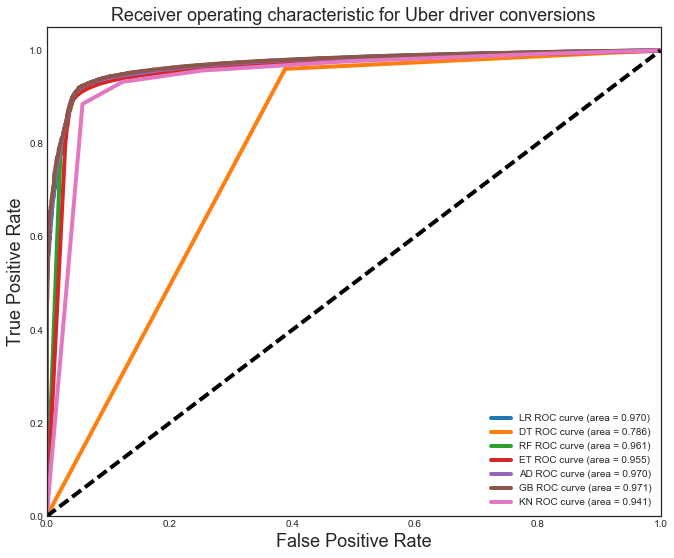

In [43]:
# Plot ROC curves for each model on same plot
plt.style.use('seaborn-white')

Y_score_lr = cross_val_predict(lr, Xt, y, cv=cv, method='predict_proba')[:,1]
Y_score_dt = cross_val_predict(dt, Xt, y, cv=cv, method='predict_proba')[:,1]
Y_score_rf = cross_val_predict(rf, Xt, y, cv=cv, method='predict_proba')[:,1]
Y_score_et = cross_val_predict(et, Xt, y, cv=cv, method='predict_proba')[:,1]
Y_score_ad = cross_val_predict(ad, Xt, y, cv=cv, method='predict_proba')[:,1]
Y_score_gb = cross_val_predict(gb, Xt, y, cv=cv, method='predict_proba')[:,1]
Y_score_kn = cross_val_predict(kn, Xt, y, cv=cv, method='predict_proba')[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

plt.figure(figsize=[11,9])

# For logistic regression, find the area under the curve and plot ROC curve
FPR[1], TPR[1], _ = roc_curve(y, Y_score_lr)
ROC_AUC[1] = auc(FPR[1], TPR[1])
plt.plot(FPR[1], TPR[1], label='LR ROC curve (area = %0.3f)' % ROC_AUC[1], linewidth=4)

# For decision tree, find the area under the curve and plot ROC curve
FPR[2], TPR[2], _ = roc_curve(y, Y_score_dt)
ROC_AUC[2] = auc(FPR[2], TPR[2])
plt.plot(FPR[2], TPR[2], label='DT ROC curve (area = %0.3f)' % ROC_AUC[2], linewidth=4)

# For random forest, find the area under the curve and plot ROC curve
FPR[3], TPR[3], _ = roc_curve(y, Y_score_rf)
ROC_AUC[3] = auc(FPR[3], TPR[3])
plt.plot(FPR[3], TPR[3], label='RF ROC curve (area = %0.3f)' % ROC_AUC[3], linewidth=4)

# For extra trees, find the area under the curve and plot ROC curve
FPR[4], TPR[4], _ = roc_curve(y, Y_score_et)
ROC_AUC[4] = auc(FPR[4], TPR[4])
plt.plot(FPR[4], TPR[4], label='ET ROC curve (area = %0.3f)' % ROC_AUC[4], linewidth=4)

# For adaboost, find the area under the curve and plot ROC curve
FPR[5], TPR[5], _ = roc_curve(y, Y_score_ad)
ROC_AUC[5] = auc(FPR[5], TPR[5])
plt.plot(FPR[5], TPR[5], label='AD ROC curve (area = %0.3f)' % ROC_AUC[5], linewidth=4)

# For gradient boosting, find the area under the curve and plot ROC curve
FPR[6], TPR[6], _ = roc_curve(y, Y_score_gb)
ROC_AUC[6] = auc(FPR[6], TPR[6])
plt.plot(FPR[6], TPR[6], label='GB ROC curve (area = %0.3f)' % ROC_AUC[6], linewidth=4)

# For knn, find the area under the curve and plot ROC curve
FPR[7], TPR[7], _ = roc_curve(y, Y_score_kn)
ROC_AUC[7] = auc(FPR[7], TPR[7])
plt.plot(FPR[7], TPR[7], label='KN ROC curve (area = %0.3f)' % ROC_AUC[7], linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Uber driver conversions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Let's also take a look at the gradient boosting model classification report and confusion matrix once we apply the model to unseen data via a train-test-split cross-validation approach.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.20, random_state=99)

In [45]:
y_pred = gb.fit(X_train,y_train).predict(X_test)

In [46]:
print('Gradient Boosting Classification Report \n')
print(classification_report(y_test, y_pred) + '\n\n')

print('Gradient Boosting Confusion Matrix \n')
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat, index=['true_driver', 'true_not_driver'],
                            columns=['predicted_driver','predicted_not_driver'])
print(confusion)

Gradient Boosting Classification Report 

             precision    recall  f1-score   support

          0       0.73      0.81      0.77      1237
          1       0.98      0.96      0.97      9700

avg / total       0.95      0.95      0.95     10937



Gradient Boosting Confusion Matrix 

                 predicted_driver  predicted_not_driver
true_driver                  1004                   233
true_not_driver               364                  9336


In [47]:
feats = pd.Series(gb.feature_importances_, index = pd.Series(X.columns).apply(lambda x: x.lower()))
feats.sort_values(ascending=True,inplace=True)

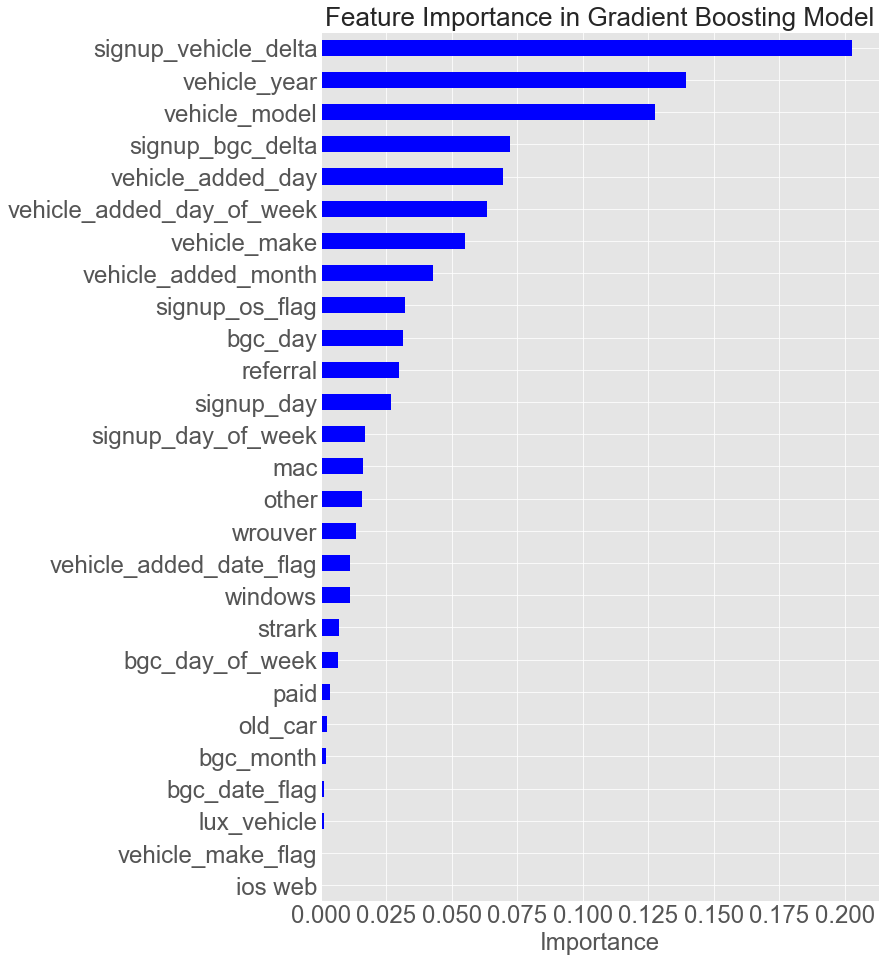

In [54]:
plt.style.use('ggplot')
feats.plot(kind = "barh", color='b', figsize=(10,16),fontsize=24)
plt.xlabel('Importance',fontsize=24)
plt.title("Feature Importance in Gradient Boosting Model", fontsize=26);

### Feature importance

From the above feature importance plot we see that the key features of our gradient boosting model were *signup_vehicle_delta* (i.e., the amount of time between signing up and registering your vehicle with Uber), *vehicle_year* and *vehicle_model*.  Interestingly, it appears that city location has little to no importance to the model.  It also appears that some of my feature engineering ideas like flagging "luxury" vehicles and cars that are older than the US average car age (11.6 years) provide almost no improved predictive power to the model.  

### Future model improvements 

In the interest of time I limited the scope of the modeling phase to include only the single best model.  I figured in a real world situation where scalability and computational time are major factors this approach may be preferred.  With that said, in order to improve upon the model we could have applied model blending, ensembling or stacking to better allow for generalization to the unseen data.  Although scikit-learn's GradientBoostingClassifier performed the best of the models I tried, I did not explore XGBoost or LightGBM and they may have provided additional improvements in model performance.  For this quick modeling phase I neglected to used regularization (i.e., Lasso and Ridge) and feature selection techniques such as SelectKBest, RFECV (recursive feature elimination and cross-validated selection), etc. to refine our variable selection, but both approaches would likely lead to model improvements.  Also worth mentioning is that all the models I used were "straight out of the box" with default values -- no hyperparameter tuning was employed during the modeling phase as time did not allow for it.  Given more time I could have used GridSearchCV to identifiy the optimal hyperparameter settings.  Lastly, bagging was not performed on models like logistic regression, decision tree, KNN, etc.  By performing bagging on these models we would have seen gains in performance due to a reduction in variance (as a result of averaging 100+ models).  

### Question 3 - *Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice). (1 Point)*

Uber can leverage the model to better predict those who will sign up but not actually complete their first trip as a driver.  It is important for us to correctly identify these people so that Uber can take appropriate action with them by applying ideas like promotional rates, driver incentives, app alerts/reminders, and email campaigns.

If we look at the plot below it clearly shows that applicants who fail to register their vehicles 30 days after first signing up with Uber almost never complete their first trip as a driver. Uber should use this knowledge to send reminders or incentives to the applicants after two weeks of no updates by the applicant. This finding is significant since *signup_vehicle_delta* (i.e., the time between signup and vehicle registration) had the highest feature importance in our gradient boosting model. The second ranked feature in terms of feature importance to the model was vehicle_year. As a way of recruiting new drivers Uber should think about targeting people driving newer cars by perhaps concentrating advertisements at new car dealerships or striking partnerships with auto loan providers and/or online new car websites.

In [49]:
new_df = pd.concat([X,y],axis=1)

In [50]:
drivers_signups = new_df[new_df['first_drive'] == 0]['signup_vehicle_delta']
not_drivers_signups = new_df[new_df['first_drive'] == 1]['signup_vehicle_delta']

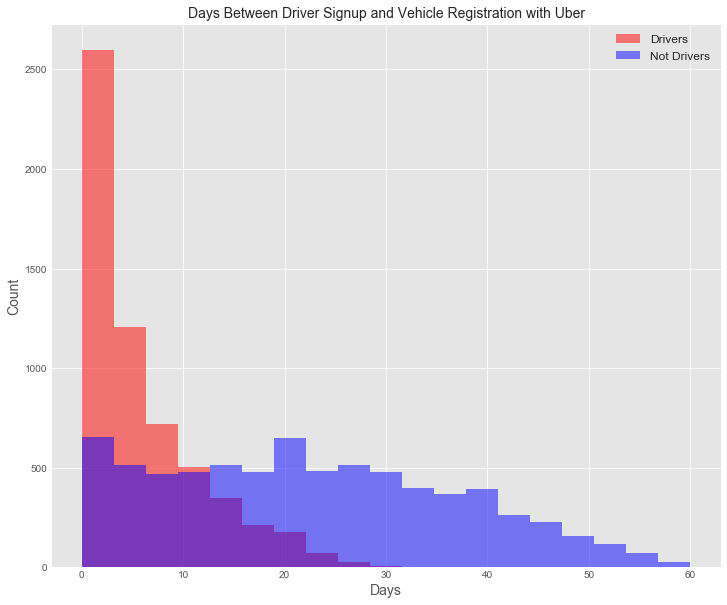

In [51]:
plt.style.use('ggplot')
bins = np.linspace(0, 60, 20)
plt.figure(figsize=(12,10))
plt.hist(drivers_signups, bins, alpha=0.5, label='Drivers', color='r')
plt.hist(not_drivers_signups, bins, alpha=0.5, label='Not Drivers', color ='b')
plt.title('Days Between Driver Signup and Vehicle Registration with Uber', fontsize=14)
plt.xlabel('Days', fontsize =14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper right', fontsize=12);